In [6]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys, time
import geopandas as gpd
from matplotlib import pyplot as plt
from Image_properties import props

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen


def inserir_vasos(array_medial_path, distance, array_pickles,pickle_dir,back_artif):   
  n_random = np.random.randint(0, len(array_pickles))  
  
  path = (pickle_dir + f'/{array_pickles[n_random]}')
  print(f'{array_pickles[n_random]}')

  arquivo_pickle = pickle.load(open(path, 'rb')) 
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values
  
  imagem_binaria_original = vessel_map.mapped_mask_values 
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 
  
  mapa_original_norm = backgen.normaliza(back_artif,mapa_original,imagem_binaria_sem_artefatos)
  
  rows, cols = mapa_original.shape  

  distancia = (rows/2) 
  
  limiar1 = backgen.encontrar_pixel_mais_frequente(mapa_original_norm)  
  
  limiar2 = backgen.encontrar_mediana_fundo_mapa(mapa_original_norm,imagem_binaria_sem_artefatos) 
   
    
  #caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path,1) # type: ignore

  maior_valor = int(distance)
  print(maior_valor)

       
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original_norm,maior_valor) 
    
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor)  
     
      
  linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path,distancia)  
  
  #Criação das linhas à direita, centro e à esquerda a partir do traçado originado pelas curvas de beizier
  dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)

  
  #Execução do algoritmo que faz a transformação do mapa expandido
  img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np,maior_tamanho)   
  
  #Máscara do mapa
  mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
  
  #Máscara do vaso
  mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path,img_out)   
  
  #Vaso binário rotacionado
  vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)   
  
  #Mapa sem artefatos
  mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)  
  
  #Vaso binário expandido e rotacionado VER AQUI
  img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
  
  #Vaso binário rotacionado sem artefatos
  vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)    
  
  try:
    mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,back_artif)
  except:
    pass  

  return  vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1

    

### Backup

In [ ]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys, time
import geopandas as gpd
from matplotlib import pyplot as plt
from Image_properties import props

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
tracados_dir = f'{root_dir}/Artificial_Lines/tracados_bezier'
#img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superficial layers@40-Image 3-20X'

array_pickles = funcoes.ler_diretorios(pickle_dir)
array_backgrounds = funcoes.ler_diretorios(background_dir)
array_tracados = funcoes.ler_diretorios(tracados_dir)


n_backgrounds = np.random.randint(0, len(array_backgrounds))
n_tracados = np.random.randint(0, len(array_tracados))
tracado = array_tracados[n_tracados]

array_medial_path = backgen.retorna_paths(f'{tracados_dir}/{tracado}')

#back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[n_backgrounds]}'))

possui_mapas =  np.full(shape = back_artif.shape, fill_value=0)

vetor_informacoes = []
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []
vetor_vasos_sem_artefados = []
vetor_mask_map = []
vetor_mask_vaso = []
vetor_mapas_originais_norm = []
vetor_limiares1 = []
vetor_limiares2 = []

for i in range(len(array_medial_path)):
#for i in range(2):  
  n_random = np.random.randint(0, len(array_pickles))  
  
  path = (pickle_dir + f'/{array_pickles[n_random]}')
  print(f'{array_pickles[n_random]}')

  arquivo_pickle = pickle.load(open(path, 'rb')) 
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values
  
  imagem_binaria_original = vessel_map.mapped_mask_values 
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 
  
  mapa_original_hist = backgen.histograma_matching(mapa_original,imagem_binaria_sem_artefatos,back_artif)
  
  rows, cols = mapa_original.shape  

  distancia = (rows/2) 
  
  limiar1 = backgen.encontrar_pixel_mais_frequente(mapa_original_hist)  
  
  limiar2 = backgen.encontrar_mediana_fundo_mapa(mapa_original_hist,imagem_binaria_sem_artefatos)  
  
  caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path[i],0) # type: ignore 

  maior_valor = np.max(caminhos_transladados[0])
  
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original_hist,maior_valor) 
  
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor) 
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,    
      "mapa_original_hist":mapa_original_hist,    
      "caminhos_transladados": caminhos_transladados,
      "maior_valor": maior_valor,
      "mapa_expandido_original": mapa_expandido_original,
      "vaso_expandido_bin": vaso_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar1": limiar1,
      "limiar2": limiar2
    }
  vetor_informacoes.append(dict)

fundo_com_vasos = back_artif.copy()

for i in range(len(array_medial_path)): 

    caminhos_transladados = vetor_informacoes[i]['caminhos_transladados'] # type: ignore
    maior_valor = vetor_informacoes[i]['maior_valor'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore    
    mapa_original_hist = vetor_informacoes[i]["mapa_original_hist"] 
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    vaso_expandido_bin = vetor_informacoes[i]['vaso_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar1 = vetor_informacoes[i]['limiar1'] # type: ignore 
    limiar2 = vetor_informacoes[i]['limiar2'] # type: ignore 
    vetor_limiares1.append(limiar1)
    vetor_limiares2.append(limiar2)
    
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)  
    
    #Criação das linhas à direita, centro e à esquerda a partir do traçado originado pelas curvas de beizier
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
   
    
    #Execução do algoritmo que faz a transformação do mapa expandido
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_original_hist,dst_array_np,maior_tamanho)   
    
    #Máscara do mapa
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
    vetor_mask_map.append(mask_map)
    
    #Máscara do vaso
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path[i],img_out)
    vetor_mask_vaso.append(mask_vaso)
    
    #Vaso binário rotacionado
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)   
    
    #Mapa sem artefatos
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)  
    
    #Vaso binário expandido e rotacionado
    img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    
    #Vaso binário rotacionado sem artefatos
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)    
    vetor_vasos_sem_artefados.append(vaso_sem_artefatos)    
    
    #mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos_1,mask_map,vaso_sem_artefatos,back_artif)
    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    
    
    try:
      mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,back_artif)
    except:
      pass
    
    try:
      fundo_com_vasos = backgen.inserir_mapa(fundo_com_vasos,vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1, possui_mapas)
    except:
      pass




plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()

img1 = Image.fromarray(fundo_com_vasos.astype(np.uint8))

img = img1.save("teste4.tiff")
    

    

### Inserindo os vasos

Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 4-20X_savedata1.pickle
525
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 3-20X_savedata1.pickle
648
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@64-Image 1-20X_savedata0.pickle
648
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata5.pickle
525
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata6.pickle
621
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata2.pickle
785
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 4-20X_savedata0.pickle
748
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@59-Image 1-20X_savedata1.pickle
731
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@59-Image 2-20X_savedata1.pickle
748
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@64-Image 1-20X_savedata0.pickle
785


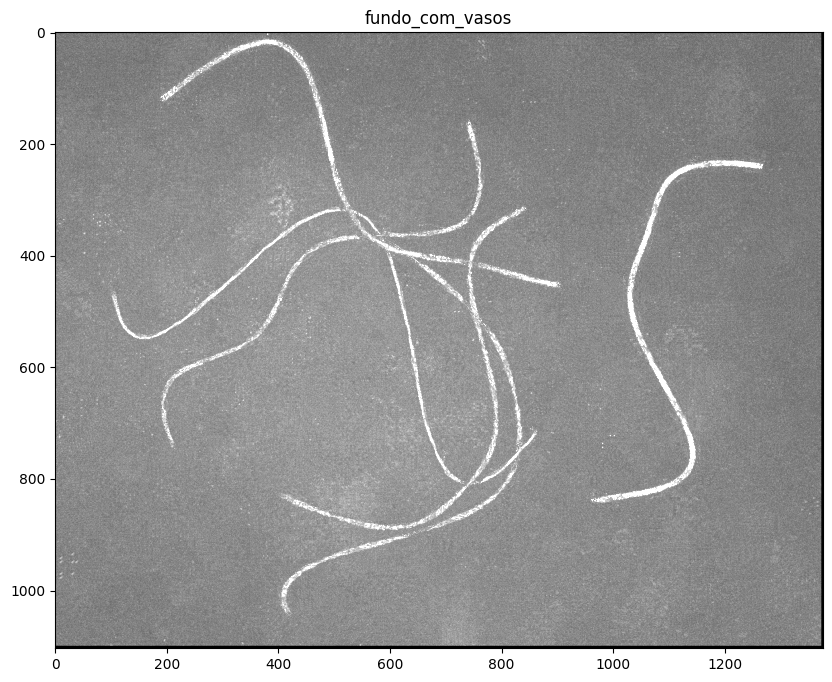

In [9]:
root_dir = f"/home/adriano/projeto_mestrado/modules"
img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
tracados_dir = f'{root_dir}/Artificial_Lines/tracados_bezier'

vetor_pickles = funcoes.ler_diretorios(pickle_dir)
array_backgrounds = funcoes.ler_diretorios(background_dir)
array_tracados = funcoes.ler_diretorios(tracados_dir)
n_backgrounds = np.random.randint(0, len(array_backgrounds))

background = np.array(Image.open(f'{background_dir}/{array_backgrounds[n_backgrounds]}'))
fundo_com_vasos = background.copy()
possui_mapas =  np.full(shape = background.shape, fill_value=0)  
for i in range(10):
   
    n_tracados = np.random.randint(0, len(array_tracados))
    tracado = array_tracados[n_tracados]

    vetor_medial_path = backgen.retorna_paths(f'{tracados_dir}/{tracado}')
    
    vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1 = inserir_vasos(vetor_medial_path[0],vetor_medial_path[1],vetor_pickles,pickle_dir,background)
    fundo_com_vasos = backgen.inserir_mapa(fundo_com_vasos,vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1, possui_mapas)
    # i = i + 2


plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()

img1 = Image.fromarray(fundo_com_vasos.astype(np.uint8))

img = img1.save("teste10.tiff")

In [ ]:
  
plt.figure(figsize=[10, 8])
plt.title("mapa_original")
plt.imshow(mapa_original, 'gray', vmin=0, vmax=60)
plt.plot()

  
plt.figure(figsize=[10, 8])
plt.title("mapa_expandido_original")
plt.imshow(mapa_expandido, 'gray', vmin=0, vmax=60)
plt.plot()


In [ ]:
# possui_mapas2 =  np.full(shape = back_artif.shape, fill_value=0)
# fundo_com_vasos = back_artif.copy()
# for i in range(10):
#     mapa_sem_artefatos_1 = vetor_mapas_sem_artefatos[i]
#     vaso_sem_artefatos = vetor_vasos_sem_artefados[i]
#     mask_map = vetor_mask_map[i]
#     #mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos_1,mask_map,vaso_sem_artefatos,back_artif)
#     mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos_1,mask_map,vaso_sem_artefatos,back_artif)
#     fundo_com_vasos = backgen.inserir_mapa(fundo_com_vasos,vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1, possui_mapas2)

plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()

img1 = Image.fromarray(fundo_com_vasos.astype(np.uint8))

img = img1.save("teste4.tiff")

### Plots dos mapas

In [ ]:

# plt.figure(figsize=[10, 8])
# plt.title("fundo com vaso")
# plt.imshow(img, 'gray', vmin=0, vmax=60)
# plt.plot()

plt.figure(figsize=[30, 30])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[30, 30])
plt.title("Mapas normalizados")
for i in range(len(vetor_mapas_originais_norm)):  
    plt.subplot(1,len(vetor_mapas_originais_norm),i+1)  
    plt.imshow(vetor_mapas_originais_norm[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
for i in range(len(vetor_mapas_originais)):    
    plt.subplot(1,len(vetor_mapas_originais),i+1)    
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)

# plt.figure(figsize=[20, 16])
# plt.title("Mapas mergeados e normalizados")
# for i in range(len(vetor_mapas_originais_merge_norm_random)):  
#     plt.subplot(1,len(vetor_mapas_originais_merge_norm_random),i+1)  
#     plt.imshow(vetor_mapas_originais_merge_norm_random[i], 'gray', vmin=0, vmax=60)
    
# plt.figure(figsize=[20, 16])
# plt.title("vetor_mapa_original_hist")
# for i in range(len(vetor_img_map_hist)):  
#     plt.subplot(1,len(vetor_img_map_hist),i+1)  
#     plt.imshow(vetor_img_map_hist[i], 'gray', vmin=0, vmax=60)



### Plots dos traçados

In [ ]:
for i in range(len(array_medial_path)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")

### Exibe os backgrounds

In [ ]:
# for i in range(len(array_backgrounds)):
#    back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[i]}'))
#    plt.figure(figsize=[10, 8])
#    plt.title(f'{array_backgrounds[i]}')
#    plt.imshow(back_artif, 'gray', vmin=0, vmax=60)
#    plt.plot()
  
